<a href="https://colab.research.google.com/github/emilia-uncc/IntroML/blob/main/assignment5/Assignment5_2_new.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [42]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

import torch
import torch.optim as optim
import torch.nn as nn
from torch.autograd import Variable


#mounting google drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [43]:
file_path = '/content/drive/My Drive/DataSets/Housing.csv'
housing = pd.DataFrame(pd.read_csv(file_path))
housing.head()

,price,area,bedrooms,bathrooms,stories,mainroad,guestroom,basement,hotwaterheating,airconditioning,parking,prefarea,furnishingstatus
0,13300000,7420,4,2,3,yes,no,no,no,yes,2,yes,furnished
1,12250000,8960,4,4,4,yes,no,no,no,yes,3,no,furnished
2,12250000,9960,3,2,2,yes,no,yes,no,no,2,yes,semi-furnished
3,12215000,7500,4,2,2,yes,no,yes,no,yes,3,yes,furnished
4,11410000,7420,4,1,2,yes,yes,yes,no,yes,2,no,furnished


In [44]:
housing.isnull().sum()*100/housing.shape[0]

price               0.0
area                0.0
bedrooms            0.0
bathrooms           0.0
stories             0.0
mainroad            0.0
guestroom           0.0
basement            0.0
hotwaterheating     0.0
airconditioning     0.0
parking             0.0
prefarea            0.0
furnishingstatus    0.0
dtype: float64

In [45]:
varlist =  ['mainroad', 'guestroom', 'basement', 'hotwaterheating', 'airconditioning', 'prefarea']

# Defining the map function
def binary_map(x):
    return x.map({'yes': 1, 'no': 0})

# Applying the function to the housing list
housing[varlist] = housing[varlist].apply(binary_map)
housing.head()

,price,area,bedrooms,bathrooms,stories,mainroad,guestroom,basement,hotwaterheating,airconditioning,parking,prefarea,furnishingstatus
0,13300000,7420,4,2,3,1,0,0,0,1,2,1,furnished
1,12250000,8960,4,4,4,1,0,0,0,1,3,0,furnished
2,12250000,9960,3,2,2,1,0,1,0,0,2,1,semi-furnished
3,12215000,7500,4,2,2,1,0,1,0,1,3,1,furnished
4,11410000,7420,4,1,2,1,1,1,0,1,2,0,furnished


In [46]:
selected_columns_indices = [1, 2, 3, 4, 10]
print(selected_columns_indices)
X = housing.iloc[:, selected_columns_indices].values
#M = 1, E = 0
Y = housing.iloc[:, 0].values

[1, 2, 3, 4, 10]


In [47]:
np.random.seed(0)
#df_train = training set, #df_test = testset
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = 0.20, random_state = 0)

In [48]:
#scale dataset
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)
print(X_train)

[[-0.71677205 -1.29437561 -0.57330726 -0.93314164 -0.81914879]
 [-0.53893631 -1.29437561 -0.57330726 -0.93314164 -0.81914879]
 [-0.98820554 -1.29437561 -0.57330726 -0.93314164 -0.81914879]
 ...
 [ 0.28004406  0.05251643  1.4755613   2.50502532  0.32555914]
 [-0.72613182  0.05251643 -0.57330726 -0.93314164  0.32555914]
 [ 0.67783452  0.05251643 -0.57330726 -0.93314164 -0.81914879]]


In [49]:
#define class with PyTorch for multidimensional model using neural network library
class linearRegression(torch.nn.Module):
    def __init__(self, inputSize, outputSize):
        super(linearRegression, self).__init__()
        self.linear = torch.nn.Linear(inputSize, outputSize)

    def forward(self, x):
        out = self.linear(x)
        return out

#----------------------training_loop--------------------------
def training_loop(n_epochs, model, criterion, optimizer, X_train, Y_train, X_test, Y_test):
    train_losses = []
    val_losses = []

    for epoch in range(n_epochs):
        #??
        inputs_train = Variable(X_train)
        outputs_train = Variable(Y_train)
        inputs_val = Variable(X_test)
        outputs_val = Variable(Y_test)

        # Clear gradient buffers because we don't want any gradient from previous epoch to carry forward, dont want to cummulate gradients
        optimizer.zero_grad()

        # get output from the model, given the inputs
        test_pred = model(inputs_train)

        # get loss for the predicted output
        loss_train = criterion(test_pred, outputs_train)

        # Forward pass and loss calculation for the test set
        with torch.no_grad():
            val_pred = model(inputs_val)
            test_loss = criterion(val_pred, Y_test)

        #print(loss)
        # get gradients w.r.t to parameters
        loss_train.backward()

        # update parameters
        optimizer.step()

        if epoch % 500 == 0:
          print(f"Epoch: {epoch}, Loss: {loss_train.item()}, val_loss: {test_loss.item()}")
        if epoch % 20 == 0:
          train_losses.append(loss_train.item())
          val_losses.append(test_loss.item())


    return train_losses, val_losses

In [50]:
#set input and output dimensions
inputDim = 5
outputDim = 1
#set learning rate and epochs
learningRate = 0.1
epochs = 5000

#create model
model = linearRegression(inputDim, outputDim)

criterion = torch.nn.MSELoss() #set lossfuntion from neural network library
optimizer_adam = torch.optim.Adam(model.parameters(), lr=learningRate) #set optimizer Adam
optimizer_sgd = torch.optim.SGD(model.parameters(), lr=learningRate) #set optimizer SGD

#arrays into tensors
X_train_tensor =torch.tensor(X_train, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)

Y_train_tensor = torch.tensor(Y_train, dtype=torch.float32)
Y_test_tensor = torch.tensor(Y_test, dtype=torch.float32)

train_losses, val_losses = training_loop(epochs,model, criterion, optimizer_sgd, X_train_tensor, Y_train_tensor, X_test_tensor, Y_test_tensor )


Epoch: 0, Loss: 26469975719936.0, val_loss: 25189238702080.0


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([436])) that is different to the input size (torch.Size([436, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([109])) that is different to the input size (torch.Size([109, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch: 500, Loss: 3644181708800.0, val_loss: 2884491542528.0
Epoch: 1000, Loss: 3644181708800.0, val_loss: 2884491542528.0
Epoch: 1500, Loss: 3644181708800.0, val_loss: 2884491542528.0
Epoch: 2000, Loss: 3644181708800.0, val_loss: 2884491542528.0
Epoch: 2500, Loss: 3644181708800.0, val_loss: 2884491542528.0
Epoch: 3000, Loss: 3644181708800.0, val_loss: 2884491542528.0
Epoch: 3500, Loss: 3644181708800.0, val_loss: 2884491542528.0
Epoch: 4000, Loss: 3644181708800.0, val_loss: 2884491542528.0
Epoch: 4500, Loss: 3644181708800.0, val_loss: 2884491542528.0


In [54]:
model = linearRegression(inputDim, outputDim)
criterion = torch.nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learningRate)

test_losses = []
losses = []

for epoch in range(epochs):
    # Converting inputs and labels to Variable
    inputs = Variable(X_train_tensor)
    labels = Variable(Y_train_tensor)
    inputs_val = Variable(X_test_tensor)
    labels_val = Variable(Y_test_tensor)

    # Clear gradient buffers because we don't want any gradient from previous epoch to carry forward, dont want to cummulate gradients
    optimizer.zero_grad()

    # get output from the model, given the inputs
    outputs = model(inputs)

    # get loss for the predicted output
    loss = criterion(outputs, labels)

    # Forward pass and loss calculation for the test set
    with torch.no_grad():
        val_pred = model(inputs_val)
        test_loss = criterion(val_pred, Y_test_tensor)

    #print(loss)
    # get gradients w.r.t to parameters
    loss.backward()

    # update parameters
    optimizer.step()

    if epoch % 500 == 0:
            #print(weights)
            print(f"Epoch: {epoch}, Loss: {loss.item()}, val_loss: {test_loss.item()}")
            losses.append(loss.item())
            test_losses.append(test_loss.item())

    #print('epoch {}, loss {}'.format(epoch, loss.item()))

Epoch: 0, Loss: 26469979914240.0, val_loss: 25189242896384.0
Epoch: 500, Loss: 26469503860736.0, val_loss: 25188768940032.0
Epoch: 1000, Loss: 26469023612928.0, val_loss: 25188299177984.0
Epoch: 1500, Loss: 26468545462272.0, val_loss: 25187825221632.0
Epoch: 2000, Loss: 26468069408768.0, val_loss: 25187357556736.0
Epoch: 2500, Loss: 26467589160960.0, val_loss: 25186883600384.0
Epoch: 3000, Loss: 26467111010304.0, val_loss: 25186407546880.0
Epoch: 3500, Loss: 26466634956800.0, val_loss: 25185933590528.0
Epoch: 4000, Loss: 26466154708992.0, val_loss: 25185461731328.0
Epoch: 4500, Loss: 26465680752640.0, val_loss: 25184994066432.0


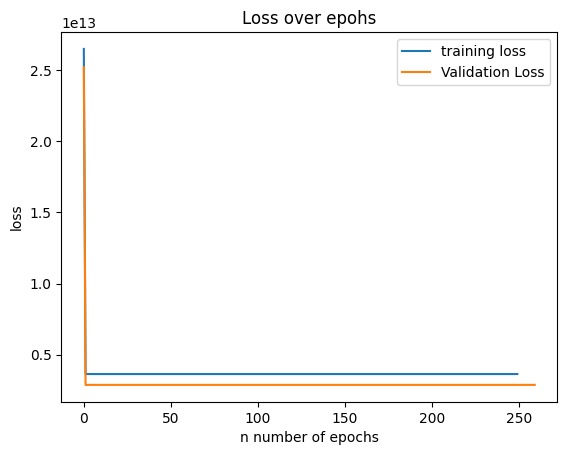

In [52]:
# 4. Plot the training and validation loss after each iteration
plt.plot(train_losses, label="training loss")
plt.plot(val_losses, label="Validation Loss")
plt.xlabel("n number of epochs")
plt.ylabel("loss")
plt.legend()
plt.title("Loss over epohs")
plt.show()